# Import Libraries

In [1]:
import re
import os
import io
import spacy
import string
import numpy as np
import pandas as pd

# Gensim
import gensim
from gensim import models
import gensim.corpora as corpora
from gensim.models import Phrases
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import warnings
warnings.filterwarnings('ignore')


# Read and Prepare Dataset

In [2]:
dataset = pd.read_csv("processedcovidvaccinereact.csv", index_col=0)
dataset.shape

(126250, 7)

In [3]:
dataset = dataset.dropna() # drop null values
dataset.shape

(125829, 7)

In [4]:
dataset.head(5)

,TweetDate,TweetText,CleanedTweet,TweetAuthor,TweetLocation,AllHashtags,Country
0,2021-03-17 23:59:34,The only way #COVID19 can mutate with variants...,onli way mutat variant viru replic host peopl ...,kemsunde,Unknown,"['COVID19', 'CovidVaccine', 'GetTheFactsGetThe...",Unknown
1,2021-03-17 23:59:20,I've now officially had my 1st dose of the #Co...,ive offici dose covidvaccin definit worth driv...,ManeckiN,The Wild Western Wastes,"['CovidVaccine', 'COVID19', 'PfizerVaccine', '...",Unknown
2,2021-03-17 23:58:31,@hendopolis Imagine if the #Brexit referendum ...,hendopoli imagin brexit referendum held secret...,raymasseytweets,England,"['Brexit', 'EU', 'TrueColours', 'Impfstoff', '...",United Kingdom
3,2021-03-17 23:58:03,@EICostheta @RicBarraArch1 @insiders Yep. The ...,eicostheta insid yep liarsnparasit veri narrow...,MikeFitzAU,Mudjimba,"['LiarsNParasites', 'CovidVaccine']",Australia
4,2021-03-17 23:57:37,This sounds like an important topic for @NickS...,thi sound like import topic nicksawyermd tnich...,stephjantzen,Greater Sacramento,"['FiresideChat', 'CovidVaccine']",Brazil


In [5]:
text_data = dataset["CleanedTweet"]  # select cleaned tweets column
#text_data = text_data[:100]

In [6]:
text__data =  [text.split() for text in text_data]  # tokenize dataset

In [7]:
text__data

[['onli',
  'way',
  'mutat',
  'variant',
  'viru',
  'replic',
  'host',
  'peopl',
  'get',
  'covidvaccin',
  'protect',
  'ourselv',
  'block',
  'viru',
  'spread',
  'mutat',
  'dr',
  'max',
  'madher',
  'bcbsla',
  'getthefactsgetthevax',
  'covidsaf'],
 ['ive',
  'offici',
  'dose',
  'covidvaccin',
  'definit',
  'worth',
  'drive',
  'without',
  'doubt',
  'thu',
  'far',
  'least',
  'onli',
  'side',
  'effect',
  'slightli',
  'sore',
  'arm',
  'hope',
  'happen',
  'pfizervaccin',
  'doyourpart',
  'pic',
  'come',
  'soon'],
 ['hendopoli',
  'imagin',
  'brexit',
  'referendum',
  'held',
  'secretli',
  'work',
  'nigel',
  'farag',
  'eu',
  'truecolour',
  'vonderleyen',
  'impfstoff',
  'covidvaccin'],
 ['eicostheta',
  'insid',
  'yep',
  'liarsnparasit',
  'veri',
  'narrow',
  'world',
  'view',
  'nobodi',
  'safe',
  'safe',
  'concept',
  'theyll',
  'never',
  'understand',
  'start',
  'abbotthockey',
  'budget',
  'amp',
  'decim',
  'foreign',
  'aid',

In [8]:
brand_keywords =['Covax','Vax','behalf_covax','Covishield','borisjohnson','johnson','johnsonandjohnson',
           'johnsonandjohnsonvaccine','moderna','modernavaccine','modernapfizer','teammoderna','pfizercovidvaccine',
           'pfizervaccine','pfizer']
text_data = []
for tweetSentence in text__data:
  
  sent = []
  for tweetWord in tweetSentence:
    if tweetWord in brand_keywords:
        sent.append(tweetWord)
       
  if sent:
    text_data.append(sent)


In [9]:
text_data[:10]

[['pfizer'],
 ['pfizer'],
 ['moderna'],
 ['moderna'],
 ['pfizer'],
 ['moderna', 'moderna'],
 ['moderna'],
 ['pfizer'],
 ['moderna'],
 ['moderna']]

### Make Bigrams for LDA Model

In [10]:
# Build the bigram models
bigram = gensim.models.Phrases(text_data, min_count=1) # higher threshold fewer phrases.

# Faster way to get a sentence clubbed as a bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

text_data = [bigram_mod[doc] for doc in text_data]

In [11]:
text_data[:10]

[['pfizer'],
 ['pfizer'],
 ['moderna'],
 ['moderna'],
 ['pfizer'],
 ['moderna', 'moderna'],
 ['moderna'],
 ['pfizer'],
 ['moderna'],
 ['moderna']]

# Build Dictionary

In [12]:
# make dictionary of complete corpus
dictionary_LDA = corpora.Dictionary(text_data)
# filter tokens below frequency of 3 words
dictionary_LDA.filter_extremes(no_below=3)
# index to words 
corpus = [dictionary_LDA.doc2bow(tok) for tok in text_data]

# Build LDA Model
# Compute Coherence and Preplexity
# Choose optimal number of topics

In [13]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    
    topics_list = [2, 4, 6, 8, 10, 12]
    coherence_values = []
    perplexity_val = []
    model_list = []
    for num_topics in topics_list:
        model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary_LDA, passes=4, alpha=0.05, eta=[0.01]*len(dictionary_LDA.keys()))
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=text_data, dictionary=dictionary_LDA, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        perplexity_val.append(model.log_perplexity(corpus))

    return model_list, coherence_values, perplexity_val

# Train LDA Model

In [14]:
# Can take a long time to run.
model_list, coherence_values, perplexity_val = compute_coherence_values(dictionary=dictionary_LDA, corpus=corpus, texts=text_data, start=2, limit=40, step=6)

# Plot Coherence Scores

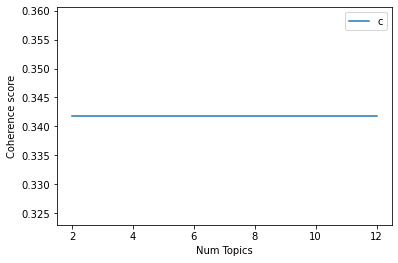

In [15]:
# Show graph
import matplotlib.pyplot as plt

topics_list = [2, 4, 6, 8, 10, 12]
plt.plot(topics_list, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Plot Perplexity Scores

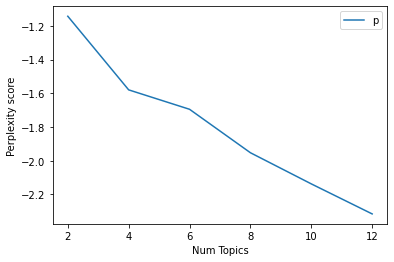

In [16]:
# Show graph
import matplotlib.pyplot as plt

topics_list = [2, 4, 6, 8, 10, 12]
plt.plot(topics_list, perplexity_val)
plt.xlabel("Num Topics")
plt.ylabel("Perplexity score")
plt.legend(("perplexity_values"), loc='best')
plt.show()

### Display Results

In [17]:
# Print the coherence scores
topics_list = [2, 4, 6, 8, 10, 12]
for m, cv, pr in zip(topics_list, coherence_values, perplexity_val):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4), " has Perplexity of", round(pr, 4))

Num Topics = 2  has Coherence Value of 0.3418  has Perplexity of -1.1428
Num Topics = 4  has Coherence Value of 0.3418  has Perplexity of -1.5796
Num Topics = 6  has Coherence Value of 0.3418  has Perplexity of -1.6948
Num Topics = 8  has Coherence Value of 0.3418  has Perplexity of -1.9526
Num Topics = 10  has Coherence Value of 0.3418  has Perplexity of -2.1374
Num Topics = 12  has Coherence Value of 0.3418  has Perplexity of -2.3156


## Train Model with Best number of topics

In [18]:
best_topic_number = 10
best_model = models.LdaModel(corpus, num_topics=best_topic_number, id2word=dictionary_LDA, passes=4, alpha=0.05, eta=[0.01]*len(dictionary_LDA.keys()))
        

In [19]:
coherencemodel = CoherenceModel(model=best_model, texts=text_data, dictionary=dictionary_LDA, coherence='c_v')
coherence_score = coherencemodel.get_coherence()
perplexity_score = best_model.log_perplexity(corpus)
print("Num Topics =", best_topic_number, " has Coherence Value of", round(coherence_score, 4), " has Perplexity of", round(perplexity_score, 4))
        

Num Topics = 10  has Coherence Value of 0.3418  has Perplexity of -2.1337


In [20]:
# display all topics with weight of all keywords
for i,topic in best_model.show_topics(formatted=True, num_topics=best_topic_number, num_words=20):
    print(str(i)+": "+ topic)
    print()

0: 0.500*"johnson" + 0.500*"borisjohnson" + 0.000*"moderna" + 0.000*"johnsonandjohnson" + 0.000*"teammoderna"

1: 1.000*"johnson" + 0.000*"moderna" + 0.000*"johnsonandjohnson" + 0.000*"borisjohnson" + 0.000*"teammoderna"

2: 1.000*"moderna" + 0.000*"johnson" + 0.000*"johnsonandjohnson" + 0.000*"teammoderna" + 0.000*"borisjohnson"

3: 1.000*"johnson" + 0.000*"moderna" + 0.000*"borisjohnson" + 0.000*"johnsonandjohnson" + 0.000*"teammoderna"

4: 1.000*"moderna" + 0.000*"johnsonandjohnson" + 0.000*"johnson" + 0.000*"teammoderna" + 0.000*"borisjohnson"

5: 0.664*"johnson" + 0.335*"moderna" + 0.000*"teammoderna" + 0.000*"borisjohnson" + 0.000*"johnsonandjohnson"

6: 0.998*"teammoderna" + 0.001*"moderna" + 0.001*"johnson" + 0.000*"borisjohnson" + 0.000*"johnsonandjohnson"

7: 1.000*"borisjohnson" + 0.000*"johnson" + 0.000*"johnsonandjohnson" + 0.000*"moderna" + 0.000*"teammoderna"

8: 1.000*"moderna" + 0.000*"teammoderna" + 0.000*"johnsonandjohnson" + 0.000*"johnson" + 0.000*"borisjohnson"

9

# Visulaize Topics

In [28]:
import pyLDAvis.gensim
warnings.filterwarnings('ignore')

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(best_model, corpus, dictionary=dictionary_LDA, mds='mmds')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.251199  0.270268       1        1  16.764142
4      0.251838  0.269279       2        1  15.550432
2      0.251373  0.269992       3        1  15.164677
7     -0.265238 -0.384213       4        1  13.297540
3     -0.328508  0.117337       5        1  10.237104
1     -0.328529  0.117220       6        1   9.603888
9      0.440394 -0.261186       7        1   8.178508
5     -0.109327  0.183438       8        1   4.593346
0     -0.307193 -0.103674       9        1   3.399050
6      0.143989 -0.478462      10        1   3.211312, topic_info=                Term         Freq        Total Category  logprob  loglift
0            moderna  2352.000000  2352.000000  Default   5.0000   5.0000
1            johnson  1180.000000  1180.000000  Default   4.0000   4.0000
2       borisjohnson   719.000000   719.000000  Default   3.0000   3.0000
3  johnsonandjohnson   392.000000   392.000000  Default   2.0000   2.0000
4        teammoderna   153.000000   153.000000  Default   1.0000   1.0000
0            moderna   804.473528  2352.618687   Topic1  -0.0000   0.7128
4        teammoderna     0.009950   153.872755   Topic1 -11.3004  -7.8604
3  johnsonandjohnson     0.009554   392.655159   Topic1 -11.3410  -8.8378
2       borisjohnson     0.009093   719.750318   Topic1 -11.3905  -9.4932
1            johnson     0.009093  1180.103217   Topic1 -11.3905  -9.9877
0            moderna   746.220749  2352.618687   Topic2  -0.0001   0.7128
4        teammoderna     0.008794   153.872755   Topic2 -11.3488  -7.9087
3  johnsonandjohnson     0.014134   392.655159   Topic2 -10.8743  -8.3711
2       borisjohnson     0.008399   719.750318   Topic2 -11.3948  -9.4975
1            johnson     0.013172  1180.103217   Topic2 -10.9448  -9.5419
0            moderna   727.715203  2352.618687   Topic3  -0.0001   0.7128
4        teammoderna     0.009066   153.872755   Topic3 -11.2932  -7.8532
3  johnsonandjohnson     0.009631   392.655159   Topic3 -11.2327  -8.7295
2       borisjohnson     0.008658   719.750318   Topic3 -11.3392  -9.4419
1            johnson     0.010308  1180.103217   Topic3 -11.1648  -9.7620
2       borisjohnson   638.108377   719.750318   Topic4  -0.0001   1.8972
4        teammoderna     0.008249   153.872755   Topic4 -11.2563  -7.8162
3  johnsonandjohnson     0.010578   392.655159   Topic4 -11.0075  -8.5043
1            johnson     0.013523  1180.103217   Topic4 -10.7619  -9.3591
0            moderna     0.008249  2352.618687   Topic4 -11.2563 -10.5434
1            johnson   491.215620  1180.103217   Topic5  -0.0001   1.4027
4        teammoderna     0.011053   153.872755   Topic5 -10.7021  -7.2620
3  johnsonandjohnson     0.011053   392.655159   Topic5 -10.7021  -8.1988
2       borisjohnson     0.011053   719.750318   Topic5 -10.7021  -8.8048
0            moderna     0.029858  2352.618687   Topic5  -9.7083  -8.9954
1            johnson   460.830934  1180.103217   Topic6  -0.0001   1.4027
4        teammoderna     0.010152   153.872755   Topic6 -10.7233  -7.2833
3  johnsonandjohnson     0.017533   392.655159   Topic6 -10.1769  -7.6736
2       borisjohnson     0.012683   719.750318   Topic6 -10.5006  -8.6034
0            moderna     0.019307  2352.618687   Topic6 -10.0805  -9.3676
3  johnsonandjohnson   392.438113   392.655159   Topic7  -0.0001   2.5031
4        teammoderna     0.010747   153.872755   Topic7 -10.5056  -7.0656
2       borisjohnson     0.010747   719.750318   Topic7 -10.5056  -8.6084
1            johnson     0.014989  1180.103217   Topic7 -10.1729  -8.7701
0            moderna     0.012014  2352.618687   Topic7 -10.3941  -9.6813
1            johnson   146.409098  1180.103217   Topic8  -0.4092   0.9936
0            moderna    73.952778  2352.618687   Topic8  -1.0922  -0.3793
4        teammoderna     0.025747   153.872755   Topic8  -9.0550  -5.6150
3  johnsonandjohnson     0.023532   392.655159   Topi

# All Topics Probabilities in each Document

In [22]:
# convert all probability distribution into dataframe (we are doing this to also keep topics having 0 probability)
# In other case topics having 0 probability will be misleading
def topics_document_to_dataframe(topics_document, num_topics):
    res = pd.DataFrame(columns=range(num_topics))
    for topic_weight in topics_document:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res


In [23]:
# find topic probabilities that model assign to all documents
topics = [best_model[corpus[i]] for i in range(len(text_data))]

In [24]:
# make dataframe of all document probability distribution
document_topic = \
pd.concat([topics_document_to_dataframe(topics_document, num_topics=best_topic_number) for topics_document in topics]) \
  .reset_index(drop=True).fillna(0)

In [25]:
document_topic.head(10)

,0,1,2,3,4,5,6,7,8,9
0,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
1,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
2,0.033333,0.033333,0.700000,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
3,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.700000,0.033333
4,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
5,0.020000,0.020000,0.820000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000
6,0.033333,0.033333,0.033333,0.033333,0.700000,0.033333,0.033333,0.033333,0.033333,0.033333
7,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
8,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.700000,0.033333
9,0.033333,0.033333,0.700000,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333


# Calculate and Find Keywords in each Document


In [26]:
def format_topics_sentences(ldamodel=best_model, corpus=corpus, texts=text_data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Per_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=best_model, corpus=corpus, texts=text_data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.10,"johnson, borisjohnson, moderna, johnsonandjohn...",[pfizer]
1,1,0.0,0.10,"johnson, borisjohnson, moderna, johnsonandjohn...",[pfizer]
2,2,2.0,0.70,"moderna, johnson, johnsonandjohnson, teammoder...",[moderna]
3,3,4.0,0.70,"moderna, johnsonandjohnson, johnson, teammoder...",[moderna]
4,4,0.0,0.10,"johnson, borisjohnson, moderna, johnsonandjohn...",[pfizer]
5,5,4.0,0.82,"moderna, johnsonandjohnson, johnson, teammoder...","[moderna, moderna]"
6,6,2.0,0.70,"moderna, johnson, johnsonandjohnson, teammoder...",[moderna]
7,7,0.0,0.10,"johnson, borisjohnson, moderna, johnsonandjohn...",[pfizer]
8,8,2.0,0.70,"moderna, johnson, johnsonandjohnson, teammoder...",[moderna]
9,9,4.0,0.70,"moderna, johnsonandjohnson, johnson, teammoder...",[moderna]
